## TM Processing

* All inputs necessary to run the template matching are already provided in the "inputs" folder and this notebook aims to show how some of them were created using [cryoCAT](https://github.com/turonova/cryocat) package.


In [1]:
# Force JAX to use CPU instead of Metal (Apple GPU)
# Metal support is experimental and doesn't support all operations
import os
os.environ['JAX_PLATFORMS'] = 'cpu'

print("JAX will use CPU only (Metal GPU disabled)")


JAX will use CPU only (Metal GPU disabled)


In [2]:
#!git clone https://github.com/turonova/cryoCAT.git
!git clone https://github.com/BGKeogh/cryoCAT.git


fatal: destination path 'cryoCAT' already exists and is not an empty directory.


In [2]:
# %cd cryoCAT
# !pip install -e .
# %cd ..
import cryocat

In [6]:
!git clone https://gitlab.mpcdf.mpg.de/bturo/gapstop_tm.git
%cd gapstop_tm
!pip install -e .
%cd ..

Cloning into 'gapstop_tm'...
remote: Enumerating objects: 1561, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 1561 (delta 72), reused 0 (delta 0), pack-reused 1423 (from 1)
Receiving objects: 100% (1561/1561), 160.06 MiB | 3.13 MiB/s, done.
Resolving deltas: 100% (769/769), done.
/Users/jackstanley/Documents/VSCode/CS562/gapstop_tm/working/gapstop_tm
Obtaining file:///Users/jackstanley/Documents/VSCode/CS562/gapstop_tm/working/gapstop_tm
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for gapstop-tm (pyproject.toml) ... done
  Created wheel for gapstop-tm: filename=gapstop_tm-0.4.dev7+g22d461edf-0.editable-py3-none-any.whl size=14320 sha256=c8baea587039d1b2bf193e8fb6e668b50dee7783ca5b282a39f10cdf0f598522
  Stored in directory: /private/v

In [22]:
!pip install mrcfile


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
mrcfile.read??

Object `mrcfile.read` not found.


In [3]:
import os
!pwd

import mrcfile
mrc_path = './data/TS_026/TS_026.rec'

if not os.path.exists(mrc_path):
  raise Exception('File not found')

with mrcfile.open(mrc_path) as mrc:
  data = mrc.data

print(data.shape)

/Users/jackstanley/Documents/VSCode/CS562/gapstop_tm/working


Exception: File not found

In [23]:
import cryocat
print("cryoCAT imported successfully!")

cryoCAT imported successfully!


In [25]:
import numpy as np
from cryocat import pana
from cryocat import cryomask
from cryocat import geom
from cryocat import wedgeutils
from cryocat import tmana
from cryocat import cryomap

import warnings
warnings.filterwarnings('ignore')

In [6]:
%cd data
import generate_angles_stochastic
%cd ..

/Users/jackstanley/Documents/VSCode/CS562/gapstop_tm/working/data
/Users/jackstanley/Documents/VSCode/CS562/gapstop_tm/working


### Setup paths

In [7]:
inputs_folder_path = './data'
angle_list_path = './data'
template_list = './data/Cryo-EM/inputs/template_list.csv' # is this needed??
wedge_path = './data/Cryo-EM/inputs/'  # not directly used in this tutorial but has to be set
results_folder = './data/tm_outputs_0'        # to evaluate your own results change it to the './inputs/tm_outputs/'

In [8]:
import os

folder_path = './data'

#folders = [f for f in os.listdir(folder_path)
#           if os.path.isdir(os.path.join(folder_path, f))]
#print(folders)



### Angle list preparation

* The angle list can be generated directly using GAPSTOP<sup>TM</sup> command line interface as described [here](https://bturo.pages.mpcdf.de/gapstop_tm/user_manual/cli.html). Note that there is currently a bug that prevents using symmetry in angle generations and thus for the microtubule example one should use cryoCAT to generate the angles with C13 symmetry.
* We generate two angular lists - one with 5 degrees angular step and one with 10 degrees. Both with symmetry C13.

In [27]:
from importlib import reload
angles_10 = geom.generate_angles(180, 13)
print(angles_10.shape)

angles = generate_angles_stochastic.generate_angles_stochastic(360, 8, 15, symmetry=8)
print(angles.shape)
print(folder_path)
np.savetxt(folder_path + '/angle_list.txt', angles_10, fmt='%.2f', delimiter=',')
#np.savetxt(angle_list_path + "angles_10_c13.txt", angles_10, fmt='%.2f', delimiter=',')


(4172, 3)
(155, 3)
./data


In [12]:
import matplotlib.pyplot as plt

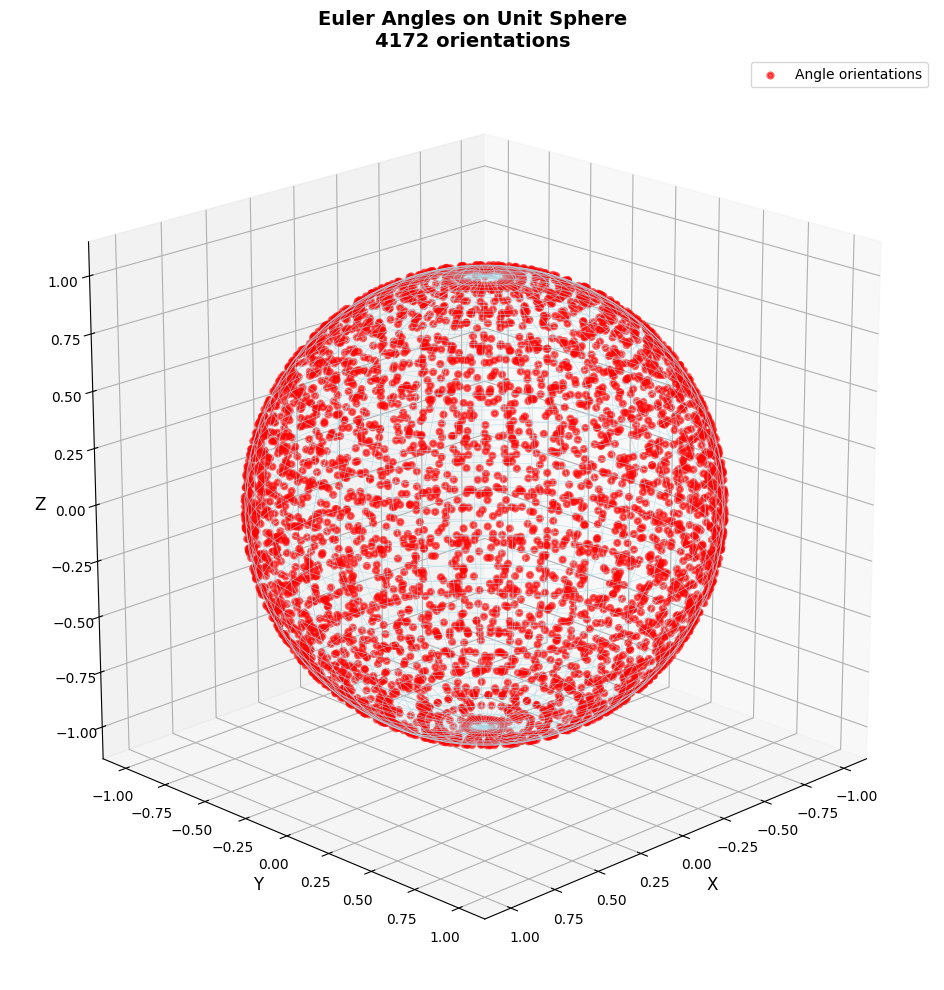

Plotted 4172 angle orientations on the sphere


In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.spatial.transform import Rotation

def euler_to_sphere_points(angles_deg):
    """
    Convert Euler angles to points on a unit sphere.
    
    Parameters:
    -----------
    angles_deg : ndarray, shape (n, 3)
        Euler angles in degrees (phi, theta, psi)
        
    Returns:
    --------
    points : ndarray, shape (n, 3)
        3D Cartesian coordinates on unit sphere
    """
    # Convert to radians
    angles_rad = np.deg2rad(angles_deg)
    
    # Create rotation objects (assuming ZXZ convention)
    rotations = Rotation.from_euler('ZXZ', angles_rad)
    
    # Apply rotations to z-axis unit vector to get points on sphere
    z_axis = np.array([0,1, 0])
    points = rotations.apply(z_axis)
    
    return points

def plot_sphere_points(angles):
    # Convert angles to sphere points
    sphere_points = euler_to_sphere_points(angles)

    # Create figure
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Create a wireframe sphere for reference
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)
    x_sphere = np.outer(np.cos(u), np.sin(v))
    y_sphere = np.outer(np.sin(u), np.sin(v))
    z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))

    ax.plot_wireframe(x_sphere, y_sphere, z_sphere, color='lightblue', 
                    alpha=0.7, linewidth=0.5)

    # Plot the points
    ax.scatter(sphere_points[:, 0], sphere_points[:, 1], sphere_points[:, 2], 
            c='red', marker='o', linewidths=2, s=15, alpha=0.6, label='Angle orientations')

    # Set labels and title
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)
    ax.set_title(f'Euler Angles on Unit Sphere\n{len(angles)} orientations', 
                fontsize=14, fontweight='bold')

    # Set equal aspect ratio
    ax.set_box_aspect([1,1,1])

    # Add legend
    ax.legend(fontsize=10)

    # Set viewing angle
    ax.view_init(elev=20, azim=45)
    

    plt.tight_layout()
    plt.show()

    print(f"Plotted {len(sphere_points)} angle orientations on the sphere")
plot_sphere_points(angles_10)



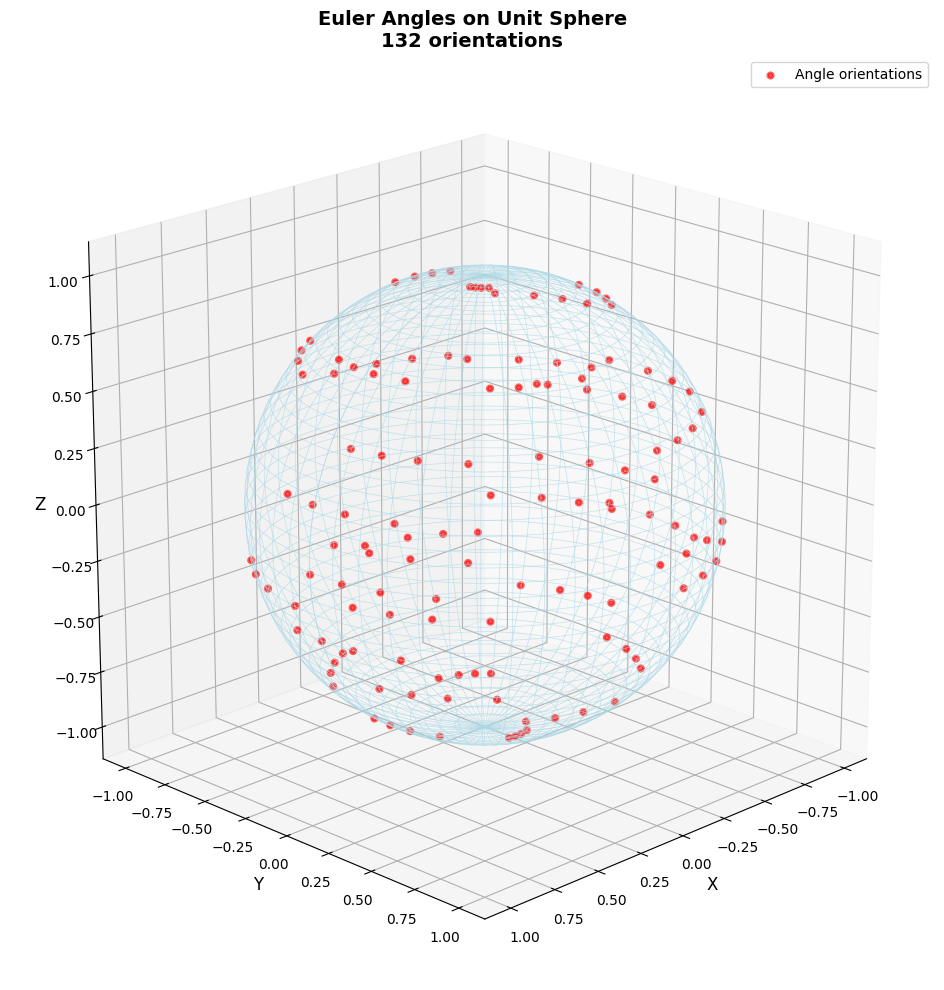

Plotted 132 angle orientations on the sphere


In [31]:
plot_sphere_points(angles)


### Mask creation

* The mask can be created in cryoCAT using [cryomask module](https://cryocat.readthedocs.io/latest/generated/cryocat.cryomask.html).

=== Detailed Score Distribution ===
Top 10 scores: [0.04227589 0.04240688 0.04250977 0.04297225 0.04320215 0.04324288
 0.04379152 0.0439122  0.04411377 0.04536628]
Bottom 10 scores: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Percentiles:
  50th percentile: 0.000000
  75th percentile: 0.004225
  90th percentile: 0.008555
  95th percentile: 0.011406
  99th percentile: 0.017430

=== Trying extraction with 90th percentile as threshold (0.008555) ===
Generating motivelist...
✓ particle_list.em created successfully!
  File size: 41712 bytes


## the total size of map is 3.37 A x 3 dimensions. The size of the

In [12]:
import mrcfile
import numpy as np
from scipy.ndimage import zoom

input_template = "./data/emd_14426.mrc"
output_template = "./data/emd_14426_downsampled.mrc"

with mrcfile.open(input_template, permissive=True) as mrc:
    data = np.copy(mrc.data)

# Downsample factor (template pixel size / tomogram pixel size)
scale_factor = 2.0 / 13.48
resized = zoom(data, scale_factor, order=1)

with mrcfile.new(output_template, overwrite=True) as out:
    out.set_data(resized.astype(np.float32))

print("✅ Downsampled template shape:", resized.shape)


✅ Downsampled template shape: (5, 5, 5)


In [13]:
_ = cryomask.spherical_mask(
    mask_size=31, #resized.shape[0],
    center=None,
    gaussian=2,
    gaussian_outwards=False,
    output_name="./data/test_mask.em"
)


In [14]:
cryocat.cryomap.mrc2em("./data/emd_14426.mrc", invert=False, overwrite=True, output_name=None)

In [15]:
from pathlib import Path
import shutil

def distribute_template_to_tomos(base_dir, template_path, overwrite=False):
    """
    Copies the template .em file into each tomogram subfolder.

    Parameters
    ----------
    base_dir : str or Path
        Path to the folder containing tomogram subdirectories (e.g., TS_026, TS_027, etc.)
    template_path : str or Path
        Path to the EMD template file (e.g., emd_14426.em)
    overwrite : bool, default=False
        If True, overwrites existing files in the subfolders
    """
    base_dir = Path(base_dir)
    template_path = Path(template_path)

    if not template_path.exists():
        raise FileNotFoundError(f"Template file not found: {template_path}")
    if not base_dir.exists():
        raise FileNotFoundError(f"Base directory not found: {base_dir}")

    tomogram_dirs = [d for d in base_dir.iterdir() if d.is_dir() and not d.name.startswith(".")]
    print(f"Found {len(tomogram_dirs)} tomogram folders in {base_dir}")

    for tomo_dir in tomogram_dirs:
        dest_path = tomo_dir / template_path.name
        if dest_path.exists() and not overwrite:
            print(f"⚠️ Skipping {tomo_dir.name}: file already exists.")
            continue

        shutil.copy2(template_path, dest_path)
        print(f"✅ Copied {template_path.name} → {tomo_dir.name}/")

    print("\n🎉 Done! Template distributed to all tomogram folders.")


# Example usage
distribute_template_to_tomos(
    base_dir="./data",
    template_path="./data/test_mask.em",
    overwrite=True  # set True if you want to replace existing copies
)


Found 3 tomogram folders in data
✅ Copied test_mask.em → TS_026/
✅ Copied test_mask.em → __pycache__/
✅ Copied test_mask.em → tm_outputs_0/

🎉 Done! Template distributed to all tomogram folders.


### Wedge list creation

* Wedge list can be created in cryoCAT using [wedgeutils module](https://cryocat.readthedocs.io/latest/generated/cryocat.wedgeutils.html).

In [16]:
import os
import mrcfile
import pandas as pd
from cryocat import wedgeutils

# === USER CONFIGURATION ===
root_base = "./data"  # Folder with all tomogram subfolders
pixel_size = 13.48
voltage = 300.0
amp_contrast = 0.07
cs = 2.7

# Template, mask, and angle list paths
template_name = "emd_14426.em"       # 80S ribosome template
mask_name = "test_mask.em"    # Cylindrical/tight ribosome mask
angle_list = "angle_list.txt"

# STAR file parameters
vol_ext = ".rec"
symmetry = "C1"
anglist_order = "zxz"
smap_name = "scores"
omap_name = "angles"
lp_rad = 16
hp_rad = 1
binning = 1
tiling = "new"

# === OUTPUT STAR FILE ===
output_star = os.path.join(root_base, "data_input.star")

# === SCAN TOMOGRAMS ===
tomograms = sorted([
    d for d in os.listdir(root_base)
    if os.path.isdir(os.path.join(root_base, d)) and d.startswith("TS_")
])

# === HELPER: Get tomogram dimensions ===
def get_tomo_dimensions(tomo_path):
    """Return tomogram dimensions (x, y, z) as a list."""
    with mrcfile.open(tomo_path, permissive=True) as mrc:
        shape = mrc.data.shape
    # MRC shape is (z, y, x)
    return [int(shape[2]), int(shape[1]), int(shape[0])]

# === CREATE WEDGE LISTS AND DATA_INPUT.STAR ===
with open(output_star, "w") as f:
    f.write("data_\n\n")
    f.write("loop_\n")
    f.write("_rootdir\n_outputdir\n_vol_ext\n_tomo_name\n_tomo_num\n_wedgelist_name\n")
    f.write("_tmpl_name\n_mask_name\n_symmetry\n_anglist_order\n_anglist_name\n")
    f.write("_smap_name\n_omap_name\n_lp_rad\n_hp_rad\n_binning\n_tiling\n\n")

    for idx, tomo in enumerate(tomograms, start=1):
        tomo_dir = os.path.join(root_base, tomo)
        output_dir = os.path.join(tomo_dir, "tm_outputs")
        os.makedirs(output_dir, exist_ok=True)

        # --- Detect tomogram file (.rec or .mrc) ---
        tomo_file = os.path.join(tomo_dir, f"{tomo}.rec")
        if not os.path.exists(tomo_file):
            tomo_file = os.path.join(tomo_dir, f"{tomo}.mrc")

        # --- Detect tilt file (.mrc.mdoc) ---
        tlt_file = os.path.join(tomo_dir, f"{tomo}.mrc.mdoc")
        if not os.path.exists(tlt_file):
            raise FileNotFoundError(f"Tilt file not found for {tomo}: expected {tomo}.mrc.mdoc")

        # --- Optional metadata ---
        ctf_file = os.path.join(tomo_dir, f"{tomo}_ctf.star")
        dose_file = os.path.join(tomo_dir, f"{tomo}_dose.txt")
        wedge_out = os.path.join(tomo_dir, "wedge_list.star")

        # --- Detect tomogram dimensions dynamically ---
        if os.path.exists(tomo_file):
            tomo_dim = get_tomo_dimensions(tomo_file)
        else:
            print(f"Tomogram file not found for {tomo}, skipping.")
            continue

        print(f"Generating wedge list for {tomo} (ID {idx})")
        print(f"   File: {os.path.basename(tomo_file)} | Dimensions: {tomo_dim}")

        # --- Create wedge list using CryoCAT ---
        wedge_df = wedgeutils.create_wedge_list_sg(
            tomo_id=idx,
            tomo_dim=tomo_dim,
            pixel_size=pixel_size,
            tlt_file=tlt_file,
            ctf_file=tlt_file,
            ctf_file_type = 'mdoc',
            dose_file=tlt_file,
            voltage=voltage,
            amp_contrast=amp_contrast,
            cs=cs,
            output_file=wedge_out
        )

        print(f"Wedge list saved: {wedge_out}")

        # --- Append to main data_input.star file ---
        f.write(f"{tomo_dir} {output_dir} {vol_ext} {os.path.basename(tomo_file)} {idx} "
                f"wedge_list.star {template_name} {mask_name} {symmetry} "
                f"{anglist_order} {angle_list} {smap_name} {omap_name} "
                f"{lp_rad} {hp_rad} {binning} {tiling}\n")

print(f"\nAll wedge lists generated and STAR file created:\n{output_star}")


Generating wedge list for TS_026 (ID 1)
   File: TS_026.rec | Dimensions: [960, 928, 1000]
Wedge list saved: ./data/TS_026/wedge_list.star

All wedge lists generated and STAR file created:
./data/data_input.star


In [ ]:
# Creates wedge list for single tomogram from mdoc file and CTF estimation file obtained from GCTF
_ = wedgeutils.create_wedge_list_sg(tomo_id=26,
                                tomo_dim = [960, 928, 1000],  # get from loading the mrc file
                                pixel_size = 13.48,
                                tlt_file = os.path.join(folder_path, "TS_026", "TS_026.mrc.mdoc"),
                                output_file= folder_path + "/TS_026/wedge_list.star",
                                drop_nan_columns=True)

In [16]:
wedgeutils.create_wedge_list_sg??

Signature:
wedgeutils.create_wedge_list_sg(
    tomo_id,
    tomo_dim,
    pixel_size,
    tlt_file,
    z_shift=0.0,
    ctf_file=None,
    ctf_file_type='gctf',
    dose_file=None,
    voltage=300.0,
    amp_contrast=0.07,
    cs=2.7,
    output_file=None,
    drop_nan_columns=True,
)
Source:   
def create_wedge_list_sg(
    tomo_id,
    tomo_dim,
    pixel_size,
    tlt_file,
    z_shift=0.0,
    ctf_file=None,
    ctf_file_type="gctf",
    dose_file=None,
    voltage=300.0,
    amp_contrast=0.07,
    cs=2.7000,
    output_file=None,
    drop_nan_columns=True,
):
    """Create a wedge list dataframe for a single tomogram/tilt series in STOPGAP format.

    Parameters
    ----------
    tomo_id : int
        The ID of the tomogram.
    tomo_dim : str or array-like
        The path to the tomogram dimensions file or dimensions specified as array-like variable. See
        :meth:`cryocat.ioutils.dimensions_load` for more information on formatting.
    pixel_size : float
        The pix

In [18]:
cryocat.cryomap.mrc2em(folder_path + '/emd_14426.mrc', invert=False, overwrite=True, output_name=None)

### Peak analysis

* The peak analysis module from [cryoCAT](https://github.com/turonova/cryocat) provides tools to analyze the template candidates for template matching in STOPAGAP or GAPSTOP<sup>TM</sup>. The results can be used to set up the parameters for the template matching.

* Here we only show how to run it for the microtubule example, for the full explanation of the template list file as well as all the steps visit the tutorial on the peak analysis on the [cryoCAT tutorial page](https://cryocat.readthedocs.io/latest/tutorials/peak_analysis/peak_analysis.html).

* Note that the following analysis can take some time due to large number of angles in angles_5_c13.txt (more than 20 minutes on a personal computer).

* IMPORTANT - some of the results are written directly to the template_list.csv and thus this file should be closed during the analysis otherwise a "Permission denied" error can occur on some systems.

### ✏️ Edit the Parameter File
Open `/content/drive/MyDrive/CryoEM/gapstop_params.star` in Colab or Google Drive, and set these values:

| Parameter | Example | Description |
|------------|----------|-------------|
| `tomo_name` | `/content/drive/MyDrive/CryoEM/tomograms/tomo_001.em` | path to your tomogram |
| `template_name` | `/content/drive/MyDrive/CryoEM/template/template.em` | path to your template |
| `mask_name` | `/content/drive/MyDrive/CryoEM/inputs/mask.em` | tight binary mask |
| `anglist_name` | `/content/drive/MyDrive/CryoEM/inputs/angles_10_c13.txt` | path to your angle list |
| `output_dir` | `/content/drive/MyDrive/CryoEM/output_gapstop` | output path |

⚠️ Make sure to **only include one** of `anglist_name` *or* `angincr` parameters — not both.


In [59]:
!gapstop -h

/Users/jackstanley/Documents/VSCode/CS562/gapstop_tm/working/gapstop_tm/src/gapstop/cli.py:110: SyntaxWarning: invalid escape sequence '\$'
  "replacement tokens that can be found by the regex '\$[xX]+' " + \
/Users/jackstanley/Documents/VSCode/CS562/gapstop_tm/working/gapstop_tm/src/gapstop/util.py:125: SyntaxWarning: invalid escape sequence '\$'
  token = re.findall("\$[xX]+", name)
usage: gapstop [-h] {run_tm,batch_params,config,generate_angles} ...

Stopgap template matching. (0.4.dev7+g22d461edf)

This application can be used for stopgap template matching.

options:
  -h, --help            show this help message and exit

subcommands:
  {run_tm,batch_params,config,generate_angles}
    run_tm              run template matching
    batch_params        create batched parameters from tomo-list
    config              create template parameter file.
    generate_angles     generate angles from cryocat.geom.


In [ ]:
# !export TF_GPU_ALLOCATOR=cuda_malloc_async

In [ ]:
os.environ['JAX_PLATFORMS'] = 'cpu'
!gapstop run_tm ./data/data_input.star -n 8

/Users/jackstanley/Documents/VSCode/CS562/gapstop_tm/working/gapstop_tm/src/gapstop/config.py:151: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  params = params.fillna(_defaults)
gapstop: template matching (version 0.4.dev7+g22d461edf)

-- Backend:
tm is running on cpu
tiles are batched over 1 device(s) per rank

-- Parameters:
rootdir            /Users/jackstanley/Documents/VSCode/CS562/gaps...
outputdir          /Users/jackstanley/Documents/VSCode/CS562/gaps...
vol_ext                                                         .rec
tomo_name          /Users/jackstanley/Documents/VSCode/CS562/gaps...
tomo_num                                                          26
wedgelist_name     /Users/jackstanley/Documents/VSCode/CS562/gaps...
tmpl_name          /Users/jackstanle

In [25]:
import os
os.path.exists('/content/drive/MyDrive/EMPIAR_10988_tomograms/TS_026/tm_outputs')

False

/content/cryoCAT/gapstop_tm/src/gapstop/config.py:151: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  params = params.fillna(_defaults)
gapstop: template matching (version 0.4.dev7+g22d461edf)

-- Backend:
tm is running on gpu
tiles are batched over 1 device(s) per rank

-- Parameters:
rootdir            /content/drive/MyDrive/Cryo-EM/GAPSTOP/tm_tuto...
outputdir          /content/drive/MyDrive/Cryo-EM/GAPSTOP/tm_tuto...
vol_ext                                                          .em
tomo_name          /content/drive/MyDrive/Cryo-EM/GAPSTOP/tm_tuto...
tomo_num                                                         126
wedgelist_name     /content/drive/MyDrive/Cryo-EM/GAPSTOP/tm_tuto...
tmpl_name          /content/drive/MyDrive/Cryo-EM/GAPSTOP/tm_tuto...
mask_name          /content/drive/MyDrive/Cryo-EM/GAPSTOP/tm_tuto...
symmetry                                                         C13
anglist_name       /content/drive/MyDrive/Cryo-EM/GAPSTOP/tm_tuto...
anglist_order                                                    zxz
smap_name                                                     scores
omap_name                                                     angles
tmap_name                                                      noise
lp_rad                                                          16.0
lp_sigma                                                         3.0
hp_rad                                                           1.0
hp_sigma                                                         2.0
binning                                                            1
calc_exp                                                        True
calc_ctf                                                        True
apply_laplacian                                                False
noise_corr                                                      True
fourier_crop                                                    True
scoring_fcn                                                     flcf
write_raw                                                      False
tiling                                                           new

Reading angles from /content/drive/MyDrive/Cryo-EM/GAPSTOP/tm_tutorial/angles_5_c13.txt
/content/cryoCAT/gapstop_tm/src/gapstop/prepare_template.py:35: RuntimeWarning: kwarg['binary'] is ignored in consistency with matlab source.
  warnings.warn(msg1, category=RuntimeWarning)
/content/cryoCAT/gapstop_tm/src/gapstop/prepare_template.py:36: RuntimeWarning: kwarg['reweight'] changes implementation details but seems to have the same effect?
  warnings.warn(msg2, category=RuntimeWarning)
/content/cryoCAT/gapstop_tm/src/gapstop/setup.py:31: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  tmpl, mask = get_template_and_mask(params)

-- Domain decomposition:
method:            new
full tomogram:     [230 500 500]
decomposed region: [230 500 500]
tilesize:          [282 552 552]

-- Computing scores...
  processed 1/1 tiles

 Score computation took 576.6s

-- Writing cryo-maps ...
  tm_outputs/scores_0_126.em
  tm_outputs/angles_0_126.em

  Cleaning up temporary output

## Regular Implementation

* Open the summary pdf files in id_0_results and id_1_results to get some statistics on the peak analysis with 10 and 5 degrees angular increment. The most differences can be seen in the cone distance map (the second to last row) - the 10 degrees results in 180.0 degrees rotation around the peak suggesting that this angular increment is too big. For that reason one should proceed with angles_5_c13.txt for template matching.

## Peform GAPSTOP Template Matching

### Particle list extraction

In [28]:
# The scores and maps do not need to be loaded before running the function, i.e., one can
# specify the input path directly as a parameter in scores_extract_particles. However,
# in case you want to play with the parameters, it is recommended to load them first
# and then only run the extract function with different parameters.
!pwd


results_folder = "./tm_outputs_1/scores_0_26.mrc"
angle_list_path = "/content/drive/MyDrive/Cryo-EM/GAPSTOP/tm_tutorial/"
scores = cryomap.read("./tm_outputs_1/scores_0_26.mrc")
angles = cryomap.read("./tm_outputs_1/angles_0_26.mrc")
angle_list = "./data/angle_list.txt"

/Users/jackstanley/Documents/VSCode/CS562/gapstop_tm/working


In [ ]:
!pwd
os.makedirs("./tm_outputs_1", exist_ok=True)
tmana.scores_extract_particles(
        scores_map = scores,
        angles_map = angles,
        angles_list = angle_list,
        tomo_id = 1,
        particle_diameter = 31,
        object_id=None,
        scores_threshold = 0.16,
        sigma_threshold=None,
        cluster_size=None,
        n_particles=None,
        output_path="./tm_outputs_1/particle_list.em",
        output_type="emmotl",
        angles_order="zxz",
        symmetry="c1",
        angles_numbering=0,
    )


/Users/jackstanley/Documents/VSCode/CS562/gapstop_tm/working


In [ ]:
# More aggressive diagnostic
print("=== Detailed Score Distribution ===")
print(f"Top 10 scores: {np.sort(scores.flatten())[-10:]}")
print(f"Bottom 10 scores: {np.sort(scores.flatten())[:10]}")
print(f"\nPercentiles:")
for pct in [50, 75, 90, 95, 99]:
    val = np.percentile(scores, pct)
    print(f"  {pct}th percentile: {val:.6f}")

# Try extraction with threshold at 90th percentile
percentile_90 = np.percentile(scores, 90)
print(f"\n=== Trying extraction with 90th percentile as threshold ({percentile_90:.6f}) ===")

tmana.scores_extract_particles(
    scores_map = scores,
    angles_map = angles,
    angles_list = angle_list,
    tomo_id = 1,
    particle_diameter = 31,
    object_id=None,
    scores_threshold = percentile_90,
    sigma_threshold=None,
    cluster_size=None,
    n_particles=None,
    output_path="./tm_outputs_1/particle_list.em",
    output_type="emmotl",
    angles_order="zxz",
    symmetry="c1",
    angles_numbering=0,
)

if os.path.exists("./tm_outputs_1/particle_list.em"):
    print("✓ particle_list.em created successfully!")
    size = os.path.getsize("./tm_outputs_1/particle_list.em")
    print(f"  File size: {size} bytes")
else:
    print("✗ Still no file created")


## Look at the motive list after template matching

In [32]:
from cryocat import cryomotl

motl = cryomotl.Motl.load("./tm_outputs_1/particle_list.em")
display(motl.df)
print("Motive list shape:", motl.df.shape)

UserInputError: Provided file ./tm_outputs_1/particle_list.em does not exist.

In [10]:
import matplotlib.pyplot as plt

# Create the histogram
plt.hist(motl.df['score'], bins=100, edgecolor='black') # 'bins' controls the number of bars, 'edgecolor' adds borders

# Add labels and title for clarity
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Sample Data")

# Display the plot
plt.show()

# Create a histogram and get the bin edges
hist, bin_edges = np.histogram(motl.df['score'], bins=50, density=True)

# Calculate the cumulative sum of the histogram
cdf_hist = 1 - np.cumsum(hist * np.diff(bin_edges))

# Plotting the cumulative histogram
plt.plot(bin_edges[1:], cdf_hist, drawstyle='steps-post')
plt.xlabel('Value')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Histogram (Approximation of CDF)')
plt.grid(True)
plt.show()


NameError: name 'motl' is not defined

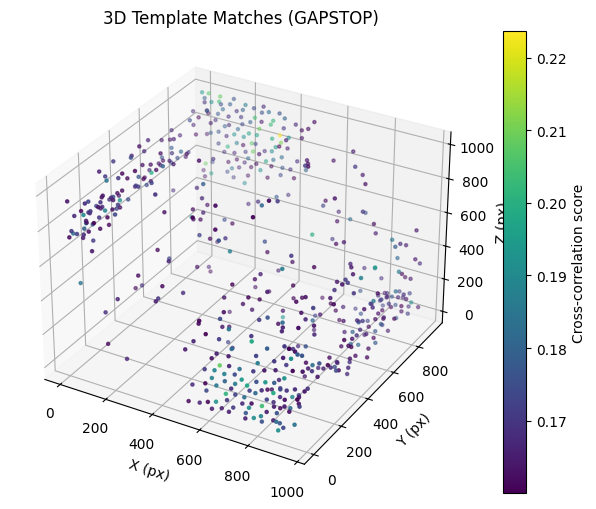

563


In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
motl_df = motl.df
# Assuming motive list columns: [x, y, z, phi, theta, psi, cc_score, ...]
x, y, z = motl_df['x'], motl_df['y'], motl_df['z']
cc_score = motl_df['score']

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(x, y, z, c=cc_score, cmap='viridis', s=5)
ax.set_title("3D Template Matches (GAPSTOP)")
ax.set_xlabel("X (px)")
ax.set_ylabel("Y (px)")
ax.set_zlabel("Z (px)")
fig.colorbar(p, ax=ax, label="Cross-correlation score")
plt.show()

print(len(x))


## Compare to the actual values given from the dataset

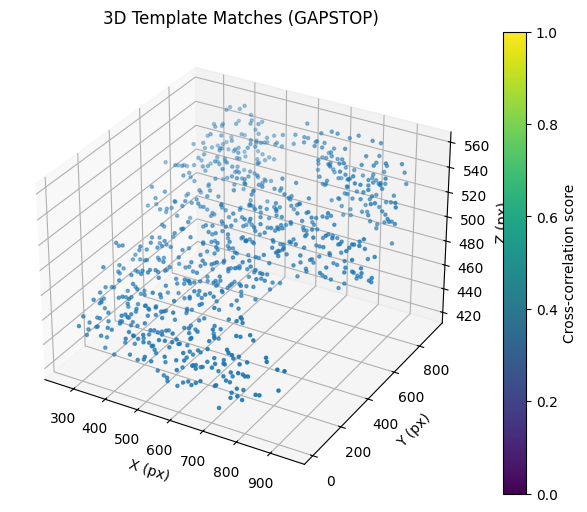

Number of particles =  838


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


TS_026_xyz = pd.read_csv("/content/drive/MyDrive/EMPIAR_10988_tomograms/TS_026/TS_026_cyto_ribosomes.csv", header=None)
TS_026_xyz.columns = ["x", "y", "z"]

x, y, z = TS_026_xyz['x'], TS_026_xyz['y'], TS_026_xyz['z']

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(x, y, z, s=5)
ax.set_title("3D Template Matches (GAPSTOP)")
ax.set_xlabel("X (px)")
ax.set_ylabel("Y (px)")
ax.set_zlabel("Z (px)")
fig.colorbar(p, ax=ax, label="Cross-correlation score")
plt.show()

print('Number of particles = ', len(x))


=== DIAGNOSTIC INFO ===
Total angles in array: 1908

Phi (in-plane) range: [0.0°, 350.0°]
Theta (polar) range: [0.0°, 180.0°]
Psi (azimuthal) range: [-177.4°, 170.2°]

First 5 angles (phi, theta, psi):
[[ 0.  0.  0.]
 [10.  0.  0.]
 [20.  0.  0.]
 [30.  0.  0.]
 [40.  0.  0.]]
Last 5 angles (phi, theta, psi):
[[310. 180.   0.]
 [320. 180.   0.]
 [330. 180.   0.]
 [340. 180.   0.]
 [350. 180.   0.]]

Unique cone directions: 53

Method 1 (unique pairs):
  X: [-0.000, 0.000]
  Y: [-1.000, 0.000]
  Z: [-1.000, 1.000]

Method 2 (all angles, phi→0):
  X: [-0.000, 0.000]
  Y: [-1.000, 0.000]
  Z: [-1.000, 1.000]


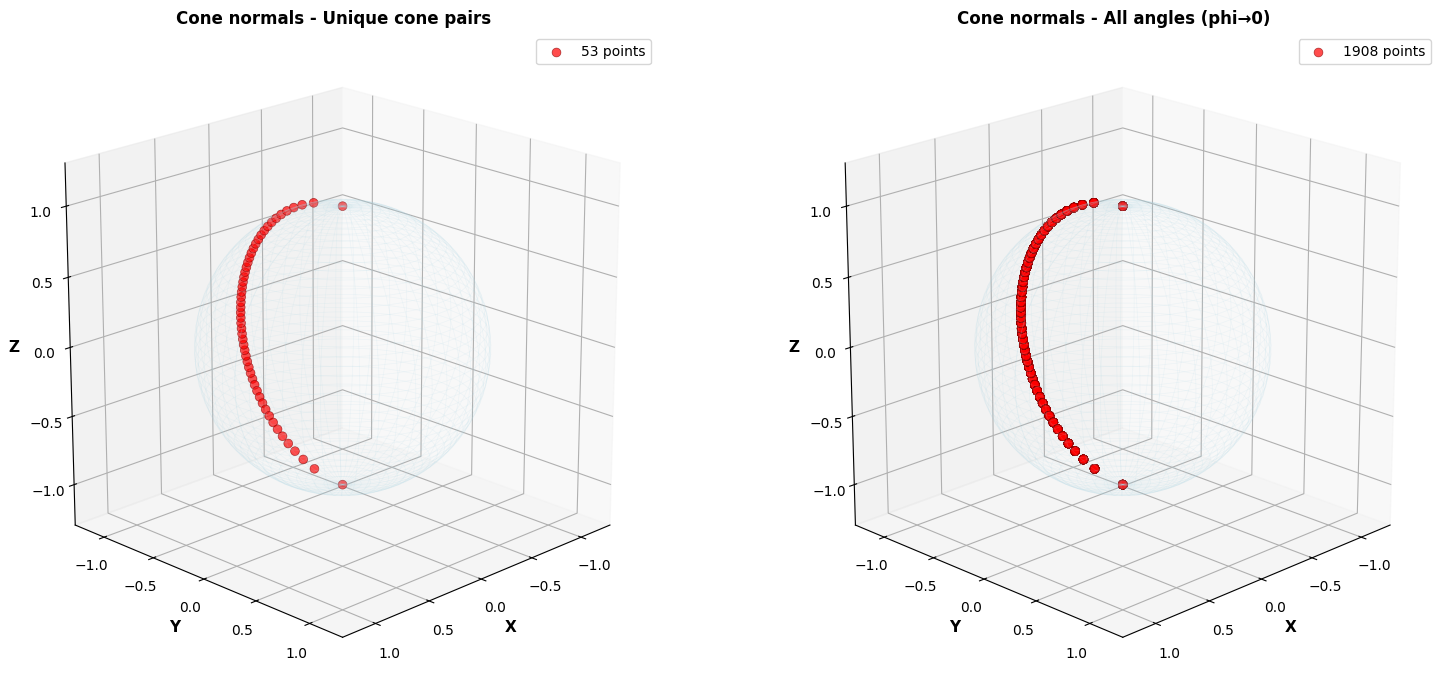

In [74]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.spatial.transform import Rotation

# Extract theta and psi from all angles
angles_array = np.asarray(angles_10)
phi = angles_array[:, 0]
theta = angles_array[:, 1]
psi = angles_array[:, 2]

print("=== DIAGNOSTIC INFO ===")
print(f"Total angles in array: {len(angles_10)}")
print(f"\nPhi (in-plane) range: [{phi.min():.1f}°, {phi.max():.1f}°]")
print(f"Theta (polar) range: [{theta.min():.1f}°, {theta.max():.1f}°]")
print(f"Psi (azimuthal) range: [{psi.min():.1f}°, {psi.max():.1f}°]")
print(f"\nFirst 5 angles (phi, theta, psi):")
print(angles_array[:5])
print(f"Last 5 angles (phi, theta, psi):")
print(angles_array[-5:])

# Get unique (theta, psi) pairs - the cone directions
cone_pairs = np.column_stack([theta, psi])
unique_cone_pairs = np.unique(np.round(cone_pairs, 5), axis=0)

print(f"\nUnique cone directions: {len(unique_cone_pairs)}")

# Method 1: Using the unique pairs
cone_angles = np.column_stack([
    np.zeros(len(unique_cone_pairs)),    # phi = 0
    unique_cone_pairs[:, 0],              # theta
    unique_cone_pairs[:, 1]               # psi
])

# Apply rotations to z-axis to get normals on unit sphere
rotations = Rotation.from_euler('ZXZ', cone_angles, degrees=True)
z_axis = np.array([0, 0, 1])
normals = rotations.apply(z_axis)

print(f"\nMethod 1 (unique pairs):")
print(f"  X: [{normals[:, 0].min():.3f}, {normals[:, 0].max():.3f}]")
print(f"  Y: [{normals[:, 1].min():.3f}, {normals[:, 1].max():.3f}]")
print(f"  Z: [{normals[:, 2].min():.3f}, {normals[:, 2].max():.3f}]")

# Also try with ALL angles (including in-plane rotations)
cone_angles_all = np.column_stack([
    np.zeros(len(angles_array)),    # phi = 0 (ignore in-plane)
    theta,
    psi
])
rotations_all = Rotation.from_euler('ZXZ', cone_angles_all, degrees=True)
normals_all = rotations_all.apply(z_axis)

print(f"\nMethod 2 (all angles, phi→0):")
print(f"  X: [{normals_all[:, 0].min():.3f}, {normals_all[:, 0].max():.3f}]")
print(f"  Y: [{normals_all[:, 1].min():.3f}, {normals_all[:, 1].max():.3f}]")
print(f"  Z: [{normals_all[:, 2].min():.3f}, {normals_all[:, 2].max():.3f}]")

# Create figure with subplots to compare
fig = plt.figure(figsize=(16, 7))

for plot_idx, (normals_to_plot, title_suffix) in enumerate([
    (normals, "Unique cone pairs"),
    (normals_all, "All angles (phi→0)")
]):
    ax = fig.add_subplot(1, 2, plot_idx + 1, projection='3d')

    # Reference sphere (wireframe)
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)
    x_sphere = np.outer(np.cos(u), np.sin(v))
    y_sphere = np.outer(np.sin(u), np.sin(v))
    z_sphere = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_wireframe(x_sphere, y_sphere, z_sphere, color='lightblue',
                      alpha=0.15, linewidth=0.5)

    # Plot normals
    ax.scatter(
        normals_to_plot[:, 0],
        normals_to_plot[:, 1],
        normals_to_plot[:, 2],
        c='red',
        marker='o',
        s=40,
        alpha=0.7,
        edgecolors='darkred',
        linewidth=0.5,
        label=f'{len(normals_to_plot)} points'
    )

    # Ensure equal aspect ratio and symmetric limits
    ax.set_xlim([-1.3, 1.3])
    ax.set_ylim([-1.3, 1.3])
    ax.set_zlim([-1.3, 1.3])
    ax.set_box_aspect([1, 1, 1])

    ax.set_xlabel('X', fontsize=11, fontweight='bold')
    ax.set_ylabel('Y', fontsize=11, fontweight='bold')
    ax.set_zlabel('Z', fontsize=11, fontweight='bold')
    ax.set_title(f'Cone normals - {title_suffix}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()


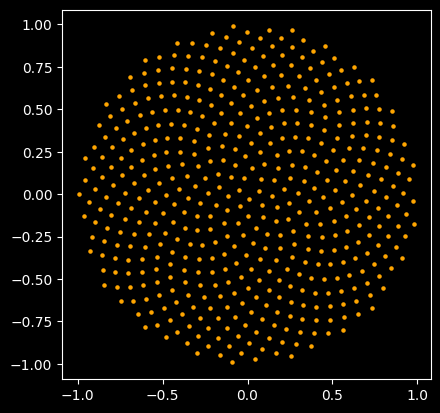

In [22]:
from numpy import pi, cos, sin, sqrt, arange

num_pts = 500
indices = arange(0, num_pts, dtype=float) + 0.5

r = sqrt(indices/num_pts)
theta = pi * (1 + 5**0.5) * indices

plt.style.use('dark_background')
plt.scatter(r*cos(theta), r*sin(theta), s=5, color='orange')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()